In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, utils
from torch.utils.data.sampler import SubsetRandomSampler
import os
import random
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from torch.autograd import Variable

In [3]:

def process_data(datadir, valid_size = 0.25, batch_size = 256):
    
    train_transforms = transforms.Compose([transforms.Resize(227),
                                               transforms.RandomRotation(degrees=30),
                                               transforms.RandomHorizontalFlip(), 
                                               transforms.ColorJitter(hue=.1, saturation=.1),
                                               transforms.ToTensor(),])
    test_transforms = transforms.Compose([transforms.Resize(227),transforms.ToTensor(),])
    
    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)
    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size*num_train))
    np.random.shuffle(indices)
    train_idx,test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    trainloader = torch.utils.data.DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)
    testloader = torch.utils.data.DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)
    
    return trainloader,testloader

In [4]:
data_dir = "./data/mendeley"

train_loader,test_loader = process_data(data_dir)

In [5]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()  
    
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, padding=1, stride=2),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 48, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),          
            nn.Conv2d(48, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),           
            nn.Conv2d(64, 96, kernel_size=5, padding=2, stride=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(4704, 1024),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(128, 2),
        )    
        self.init_bias()
    
    def init_bias(self):
        for layer in self.features:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)        
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x


In [6]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_Model().to(device)

In [7]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [8]:
def accuracy(fp,y):
    preds = fp.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

In [9]:
def train(model, device, data_itr, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    for x,y in data_itr:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        fp = model(x)
        loss = criterion(fp,y)
        acc = accuracy(fp,y)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += float(loss.item())
        epoch_acc += float(acc.item())
    return epoch_loss / len(data_itr), epoch_acc / len(data_itr)

In [10]:
def evaluate(model, device, data_itr, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    with torch.no_grad():
        for x,y in data_itr:
            x = x.to(device)
            y = y.to(device)
            
            fp = model(x)
            loss = criterion(fp,y)
            acc = accuracy(fp,y)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(data_itr), epoch_acc / len(data_itr)

In [10]:
epochs = 1500
SAVE_DIR = 'models'
CKPT_SAVE_PATH = os.path.join(SAVE_DIR, 'cnn_crack_mendeleys.pth.tar')
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'cnn_crack_mendeleys_model.pt')

best_val_loss = float('inf')

# if not os.path.isdir(f'{SAVE_DIR}'):
#     os.makedirs(f'{SAVE_DIR}')

Epochs = []
Training_loss = []
Training_accuracy = []
Validation_loss = []
Validation_accuracy = []
    
for epoch in range(epochs):
    to = time.time()
    train_loss,train_acc = train(model, device, train_loader, optimizer, criterion)
    val_loss,val_acc = evaluate(model, device, test_loader, criterion)
    tepoch = time.time() - to
    
    Epochs.append(epoch+1)
    Training_loss.append(train_loss)
    Training_accuracy.append(train_acc)
    Validation_accuracy.append(val_acc)
    Validation_loss.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch+1
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        
    if epoch%50 == 0:
        torch.save({
            'epoch': Epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': Training_loss,
            'valid_loss': Validation_loss,
            'train_acc': Training_accuracy,
            'val_acc': Validation_accuracy,
            }, CKPT_SAVE_PATH)
        
    print("Epoch: %4d | Training loss: %.3f | Training Accuracy: %5.2f | Valid_loss: %.3f | Valid_accuracy: %5.2f | Time: %.3fsec" %(epoch+1, train_loss, train_acc*100, val_loss, val_acc*100, tepoch))  

Epoch:    1 | Training loss: 0.131 | Training Accuracy: 95.39 | Valid_loss: 0.607 | Valid_accuracy: 78.37 | Time: 270.467sec
Epoch:    2 | Training loss: 0.038 | Training Accuracy: 98.90 | Valid_loss: 0.080 | Valid_accuracy: 97.94 | Time: 277.681sec
Epoch:    3 | Training loss: 0.031 | Training Accuracy: 99.10 | Valid_loss: 5.264 | Valid_accuracy: 49.43 | Time: 276.590sec
Epoch:    4 | Training loss: 0.027 | Training Accuracy: 99.23 | Valid_loss: 1.726 | Valid_accuracy: 55.85 | Time: 275.862sec
Epoch:    5 | Training loss: 0.018 | Training Accuracy: 99.51 | Valid_loss: 0.018 | Valid_accuracy: 99.30 | Time: 276.297sec
Epoch:    6 | Training loss: 0.015 | Training Accuracy: 99.63 | Valid_loss: 0.024 | Valid_accuracy: 99.18 | Time: 276.566sec
Epoch:    7 | Training loss: 0.014 | Training Accuracy: 99.64 | Valid_loss: 0.028 | Valid_accuracy: 99.38 | Time: 277.366sec
Epoch:    8 | Training loss: 0.014 | Training Accuracy: 99.63 | Valid_loss: 0.014 | Valid_accuracy: 99.51 | Time: 276.769sec


Epoch:   67 | Training loss: 0.004 | Training Accuracy: 99.89 | Valid_loss: 0.004 | Valid_accuracy: 99.86 | Time: 279.074sec
Epoch:   68 | Training loss: 0.003 | Training Accuracy: 99.91 | Valid_loss: 0.003 | Valid_accuracy: 99.90 | Time: 277.997sec
Epoch:   69 | Training loss: 0.003 | Training Accuracy: 99.91 | Valid_loss: 0.003 | Valid_accuracy: 99.91 | Time: 277.930sec
Epoch:   70 | Training loss: 0.003 | Training Accuracy: 99.92 | Valid_loss: 0.468 | Valid_accuracy: 86.66 | Time: 278.543sec
Epoch:   71 | Training loss: 0.002 | Training Accuracy: 99.94 | Valid_loss: 0.004 | Valid_accuracy: 99.87 | Time: 278.431sec
Epoch:   72 | Training loss: 0.002 | Training Accuracy: 99.94 | Valid_loss: 0.003 | Valid_accuracy: 99.94 | Time: 278.203sec
Epoch:   73 | Training loss: 0.003 | Training Accuracy: 99.90 | Valid_loss: 0.003 | Valid_accuracy: 99.92 | Time: 278.710sec
Epoch:   74 | Training loss: 0.004 | Training Accuracy: 99.94 | Valid_loss: 0.016 | Valid_accuracy: 99.68 | Time: 279.209sec


Epoch:  133 | Training loss: 0.000 | Training Accuracy: 99.98 | Valid_loss: 0.005 | Valid_accuracy: 99.92 | Time: 278.286sec
Epoch:  134 | Training loss: 0.001 | Training Accuracy: 99.98 | Valid_loss: 0.006 | Valid_accuracy: 99.89 | Time: 278.601sec
Epoch:  135 | Training loss: 0.002 | Training Accuracy: 99.95 | Valid_loss: 0.004 | Valid_accuracy: 99.93 | Time: 282.022sec
Epoch:  136 | Training loss: 0.002 | Training Accuracy: 99.95 | Valid_loss: 0.010 | Valid_accuracy: 99.72 | Time: 279.274sec
Epoch:  137 | Training loss: 0.001 | Training Accuracy: 99.96 | Valid_loss: 0.005 | Valid_accuracy: 99.89 | Time: 280.936sec
Epoch:  138 | Training loss: 0.001 | Training Accuracy: 99.97 | Valid_loss: 0.015 | Valid_accuracy: 99.79 | Time: 279.733sec
Epoch:  139 | Training loss: 0.003 | Training Accuracy: 99.93 | Valid_loss: 0.005 | Valid_accuracy: 99.90 | Time: 278.672sec
Epoch:  140 | Training loss: 0.003 | Training Accuracy: 99.95 | Valid_loss: 0.004 | Valid_accuracy: 99.91 | Time: 277.474sec


Epoch:  199 | Training loss: 0.001 | Training Accuracy: 99.99 | Valid_loss: 0.009 | Valid_accuracy: 99.89 | Time: 279.352sec
Epoch:  200 | Training loss: 0.003 | Training Accuracy: 99.92 | Valid_loss: 0.004 | Valid_accuracy: 99.88 | Time: 278.420sec
Epoch:  201 | Training loss: 0.001 | Training Accuracy: 99.97 | Valid_loss: 0.023 | Valid_accuracy: 99.68 | Time: 277.583sec
Epoch:  202 | Training loss: 0.001 | Training Accuracy: 99.99 | Valid_loss: 0.011 | Valid_accuracy: 99.90 | Time: 280.474sec
Epoch:  203 | Training loss: 0.001 | Training Accuracy: 99.97 | Valid_loss: 0.005 | Valid_accuracy: 99.91 | Time: 279.079sec
Epoch:  204 | Training loss: 0.001 | Training Accuracy: 99.97 | Valid_loss: 0.007 | Valid_accuracy: 99.87 | Time: 280.925sec
Epoch:  205 | Training loss: 0.000 | Training Accuracy: 99.99 | Valid_loss: 0.009 | Valid_accuracy: 99.88 | Time: 279.222sec
Epoch:  206 | Training loss: 0.001 | Training Accuracy: 99.99 | Valid_loss: 0.014 | Valid_accuracy: 99.86 | Time: 278.652sec


Epoch:  265 | Training loss: 0.001 | Training Accuracy: 99.98 | Valid_loss: 0.010 | Valid_accuracy: 99.89 | Time: 280.549sec
Epoch:  266 | Training loss: 0.001 | Training Accuracy: 99.99 | Valid_loss: 0.009 | Valid_accuracy: 99.85 | Time: 279.859sec
Epoch:  267 | Training loss: 0.000 | Training Accuracy: 99.98 | Valid_loss: 0.007 | Valid_accuracy: 99.89 | Time: 278.510sec
Epoch:  268 | Training loss: 0.000 | Training Accuracy: 100.00 | Valid_loss: 0.011 | Valid_accuracy: 99.88 | Time: 277.737sec
Epoch:  269 | Training loss: 0.000 | Training Accuracy: 99.99 | Valid_loss: 0.012 | Valid_accuracy: 99.91 | Time: 279.061sec
Epoch:  270 | Training loss: 0.002 | Training Accuracy: 99.97 | Valid_loss: 0.008 | Valid_accuracy: 99.89 | Time: 278.388sec
Epoch:  271 | Training loss: 0.001 | Training Accuracy: 99.98 | Valid_loss: 0.008 | Valid_accuracy: 99.90 | Time: 278.130sec
Epoch:  272 | Training loss: 0.000 | Training Accuracy: 99.98 | Valid_loss: 0.010 | Valid_accuracy: 99.92 | Time: 278.735sec

Epoch:  331 | Training loss: 0.000 | Training Accuracy: 100.00 | Valid_loss: 0.013 | Valid_accuracy: 99.86 | Time: 281.450sec
Epoch:  332 | Training loss: 0.000 | Training Accuracy: 99.99 | Valid_loss: 0.053 | Valid_accuracy: 99.71 | Time: 285.074sec
Epoch:  333 | Training loss: 0.001 | Training Accuracy: 99.98 | Valid_loss: 0.018 | Valid_accuracy: 99.86 | Time: 280.265sec
Epoch:  334 | Training loss: 0.002 | Training Accuracy: 99.96 | Valid_loss: 0.025 | Valid_accuracy: 99.84 | Time: 281.690sec
Epoch:  335 | Training loss: 0.002 | Training Accuracy: 99.97 | Valid_loss: 0.013 | Valid_accuracy: 99.86 | Time: 286.841sec
Epoch:  336 | Training loss: 0.000 | Training Accuracy: 100.00 | Valid_loss: 0.015 | Valid_accuracy: 99.87 | Time: 285.029sec
Epoch:  337 | Training loss: 0.002 | Training Accuracy: 99.96 | Valid_loss: 0.007 | Valid_accuracy: 99.87 | Time: 278.345sec
Epoch:  338 | Training loss: 0.001 | Training Accuracy: 99.98 | Valid_loss: 0.010 | Valid_accuracy: 99.84 | Time: 277.265se

KeyboardInterrupt: 

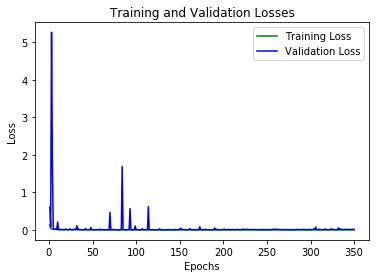

In [11]:
#Plotting graphs
#Loss curves
plt.plot(Epochs, Training_loss, 'g', label='Training Loss')
plt.plot(Epochs, Validation_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('mendeley_loss.png')
plt.show()

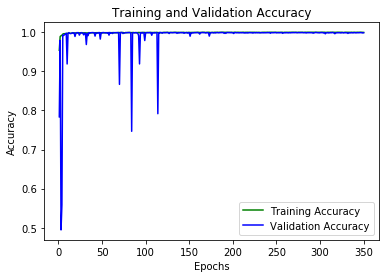

In [12]:
#Accuracy Curves 
plt.plot(Epochs, Training_accuracy, 'g', label='Training Accuracy')
plt.plot(Epochs, Validation_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('mendeley_accuracy.png')
plt.show()

In [21]:
checkpoint = torch.load('./models/cnn_crack_mendeleys.pth.tar')
model.load_state_dict(checkpoint['model_state_dict'])
model.to('cpu')
model.eval()
with torch.no_grad():
    for x,y in test_loader:
        x = x.to('cpu')
        y = y.to('cpu')
        fp = model(x)
        y_pred = fp.max(1, keepdim=True)[1]
        print('Accuracy Score: ', accuracy_score(y,y_pred))
        print(confusion_matrix(y,y_pred))
        
        print(classification_report(y,y_pred))

Accuracy Score:  1.0
[[110   0]
 [  0 146]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00       146

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

Accuracy Score:  1.0
[[136   0]
 [  0 120]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00       120

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

Accuracy Score:  1.0
[[128   0]
 [  0 128]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       128

    accuracy                           1.00       

Accuracy Score:  1.0
[[140   0]
 [  0 116]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       140
           1       1.00      1.00      1.00       116

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

Accuracy Score:  1.0
[[121   0]
 [  0 135]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       1.00      1.00      1.00       135

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

Accuracy Score:  1.0
[[127   0]
 [  0 129]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       127
           1       1.00      1.00      1.00       129

    accuracy                           1.00       

In [11]:
device = 'cpu'
checkpoint = torch.load('./models/cnn_crack_mendeleys_350.pth.tar')
test_transforms = transforms.Compose([transforms.Resize(227),transforms.ToTensor(),])
model_predict = CNN_Model().to(device)
model_predict.load_state_dict(checkpoint['model_state_dict'])
model_predict = model_predict.eval()

In [22]:
image = Image.open('./test_images/test7.jpg')
image = image.resize((227,227))
image_tensor = test_transforms(image).float()
image_tensor = image_tensor.unsqueeze_(0)
inp = Variable(image_tensor)
inp = inp.to(device)
output = model_predict(inp)
index = output.data.cpu().numpy().argmax()
print(index)

0
